# Earthquake Predictor ETL

`By Aditya srichandan`

In [1]:
import numpy as np  
import pandas as pd  
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
import os
import datetime as dt
import matplotlib.pyplot as plt

#### Get past 30 days earthquake data from [earthquake.usgs.gov](https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php) that is being updated every minute (live).
#### Lets import the dataset downloaded from here :- https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/all_month.csv

* Here we are extracting the data from given site and store it in database using SQL engine only for IPYBN and project walkthrough purpose, but in the web application we need live data since the site updates its data every minute. Hence we do not store the data in any database during application deployement but rathar extract the data and perfom only ET (Extract and Transform) and continue the rest of the process.

In [2]:
df=pd.read_csv('all_month.csv')

### Features in the dataset

* time ---------------------- Time when the event occurred. Times are reported in milliseconds since the epoch 
* latitude ------------------- Decimal degrees latitude. Negative values for southern latitudes.
* longitude ------------------ Decimal degrees longitude. Negative values for western longitudes.
* depth ---------------------- Depth of the event in kilometers.
* mag ------------------------ Magnitude of event occured.
* magType -------------------- The method or algorithm used to calculate the preferred magnitude
* nst ------------------------ The total number of seismic stations used to determine earthquake location.
* gap ------------------------ The largest azimuthal gap between azimuthally adjacent stations (in degrees).
* dmin ----------------------- Horizontal distance from the epicenter to the nearest station (in degrees).
* rms ------------------------ The root-mean-square (RMS) travel time residual, in sec, using all weights.
* net ------------------------- The ID of a data source contributor for event occured.
* id -------------------------- A unique identifier for the event. 
* types ----------------------- A comma-separated list of product types associated to this event.
* place ----------------------- named geographic region near to the event.
* type ------------------------ Type of seismic event.
* locationSource -------------- The network that originally authored the reported location of this event.
* magSource ------------------- Network that originally authored the reported magnitude for this event.
* horizontalError ------------- Uncertainty of reported location of the event in kilometers.
* depthError ------------------ The depth error, three principal errors on a vertical line.
* magError -------------------- Uncertainty of reported magnitude of the event.
* magNst ---------------------- The total number of seismic stations to calculate the magnitude of earthquake.
* status ---------------------- Indicates whether the event has been reviewed by a human.




In [3]:
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2020-08-11T10:18:15.699Z,61.280000,-149.635500,30.80,1.30,ml,NaN,NaN,NaN,0.49,...,2020-08-11T10:26:13.058Z,"2 km N of Elmendorf Air Force Base, Alaska",earthquake,NaN,0.10,NaN,NaN,automatic,ak,ak
1,2020-08-11T10:12:52.490Z,33.583833,-116.802000,7.10,0.69,ml,37.0,41.0,0.03313,0.21,...,2020-08-11T10:16:36.077Z,"12km WNW of Anza, CA",earthquake,0.28,0.68,0.134,20.0,automatic,ci,ci
2,2020-08-11T10:02:20.820Z,35.744500,-117.528333,0.89,0.64,ml,9.0,163.0,0.18810,0.19,...,2020-08-11T10:05:51.249Z,"12km WSW of Searles Valley, CA",earthquake,0.47,0.95,0.231,7.0,automatic,ci,ci
3,2020-08-11T09:59:25.820Z,33.246167,-115.667000,3.27,1.42,ml,27.0,83.0,0.07307,0.19,...,2020-08-11T10:02:59.960Z,"13km SSE of Bombay Beach, CA",earthquake,0.34,0.68,0.214,28.0,automatic,ci,ci
4,2020-08-11T09:55:14.270Z,65.260200,-162.984200,3.20,2.20,ml,NaN,NaN,NaN,0.77,...,2020-08-11T10:24:31.874Z,"67 km NNE of White Mountain, Alaska",earthquake,NaN,0.30,NaN,NaN,automatic,ak,ak


In [4]:
df.shape

(14150, 22)

In [5]:
df.describe()

,latitude,longitude,depth,mag,nst,gap,dmin,rms,horizontalError,depthError,magError,magNst
count,14150.000000,14150.000000,14150.000000,14149.000000,9960.000000,11163.000000,10192.000000,14150.000000,8529.000000,14150.000000,8972.000000,9306.000000
mean,39.489640,-116.593391,18.423449,1.479324,19.871084,112.598592,0.411993,0.265078,1.455368,7.591443,0.224856,15.830862
std,16.468250,55.310766,47.851676,1.108082,14.250814,55.766983,1.733845,0.263190,2.768131,614.493953,0.354660,29.052773
min,-65.352200,-179.941300,-3.510000,-1.430000,2.000000,13.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000
25%,35.614208,-148.862825,3.510000,0.790000,11.000000,70.930000,0.021000,0.090000,0.270000,0.450000,0.111000,5.000000
50%,38.154200,-118.176250,7.560000,1.260000,16.000000,101.350000,0.049710,0.160000,0.430000,0.745000,0.164000,10.000000
75%,51.835783,-116.888375,13.200000,1.880000,24.000000,143.630000,0.109784,0.370000,0.760000,1.640000,0.230000,18.000000
max,87.349200,179.928200,636.080000,7.800000,196.000000,355.000000,40.927000,2.170000,26.400000,73091.100000,5.320000,726.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14150 entries, 0 to 14149
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   time             14150 non-null  object 
 1   latitude         14150 non-null  float64
 2   longitude        14150 non-null  float64
 3   depth            14150 non-null  float64
 4   mag              14149 non-null  float64
 5   magType          14149 non-null  object 
 6   nst              9960 non-null   float64
 7   gap              11163 non-null  float64
 8   dmin             10192 non-null  float64
 9   rms              14150 non-null  float64
 10  net              14150 non-null  object 
 11  id               14150 non-null  object 
 12  updated          14150 non-null  object 
 13  place            14150 non-null  object 
 14  type             14150 non-null  object 
 15  horizontalError  8529 non-null   float64
 16  depthError       14150 non-null  float64
 17  magError    

##### We can see lots of null values of certain features, but as part of data wrangling and feature engineering we consider only certain features in final dataframe, hence I choose simply drop or ignore the null values

In [7]:
df.isnull().sum()

time                  0
latitude              0
longitude             0
depth                 0
mag                   1
magType               1
nst                4190
gap                2987
dmin               3958
rms                   0
net                   0
id                    0
updated               0
place                 0
type                  0
horizontalError    5621
depthError            0
magError           5178
magNst             4844
status                0
locationSource        0
magSource             0
dtype: int64

##### Visualize latitude and longitude feature from 'df' dataframe to see where the points fall from the feature set

Below data has been taken from 2020-07-05 to 2020-08-04 only for project walkthrough, but for the web application that has been deployed [here](http://srichaditya3098.pythonanywhere.com/) queries real time data that updates every minute.

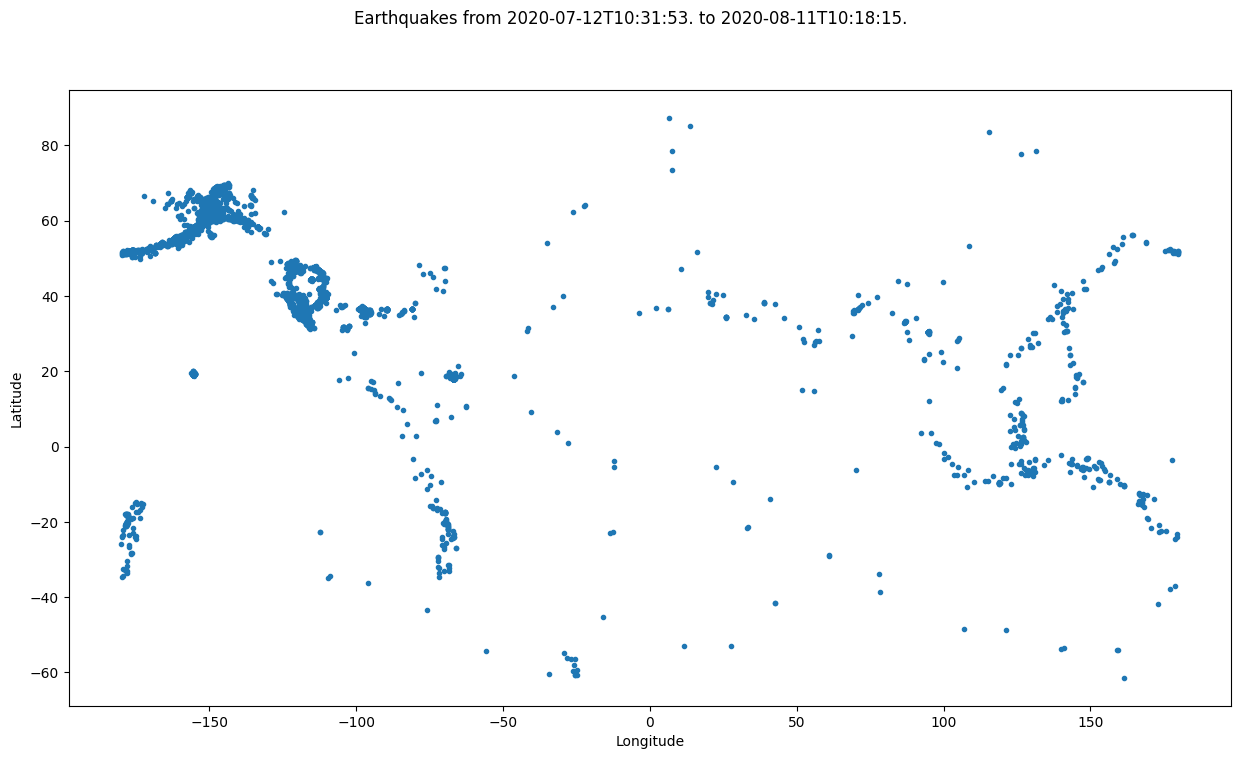

In [8]:
rounding_factor = 10
fig, ax = plt.subplots(figsize=(15,8))

# latitude and longitude of earthquake site of top 10500 samples.
plt.plot(np.round(df['longitude'].head(10500),rounding_factor), 
         np.round(df['latitude'].head(10500),rounding_factor),
         linestyle='none', marker='.')

plt.suptitle('Earthquakes from ' + str(np.min(df['time']))[:20] + ' to ' + str(np.max(df['time']))[:20])
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

#### Clean up the data by first extracting only date from 'time' column by considering string[ : 10]. hence we can get desired date

In [9]:
df = df.sort_values('time', ascending=True)

#Date extraction
df['date'] = df['time'].str[0:10]
df.head()

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource,date
14149,2020-07-12T10:31:53.318Z,67.791600,-158.636400,15.00,1.10,ml,NaN,NaN,NaN,0.42,...,"85 km NNW of Ambler, Alaska",earthquake,NaN,0.20,NaN,NaN,reviewed,ak,ak,2020-07-12
14148,2020-07-12T10:38:04.580Z,33.177833,-116.127833,11.36,0.72,ml,35.0,60.0,0.040210,0.19,...,"4km N of Ocotillo Wells, CA",earthquake,0.24,0.34,0.158,12.0,reviewed,ci,ci,2020-07-12
14147,2020-07-12T10:38:50.280Z,38.816334,-122.813500,3.17,0.91,md,22.0,46.0,0.007542,0.02,...,"7km NW of The Geysers, CA",earthquake,0.26,0.50,0.130,3.0,automatic,nc,nc,2020-07-12
14146,2020-07-12T10:40:29.962Z,63.047100,-150.433700,107.20,1.10,ml,NaN,NaN,NaN,0.21,...,"63 km NNE of Petersville, Alaska",earthquake,NaN,0.50,NaN,NaN,reviewed,ak,ak,2020-07-12
14145,2020-07-12T10:50:55.660Z,36.073167,-117.642167,4.75,0.88,ml,13.0,85.0,0.110600,0.14,...,"28km E of Coso Junction, CA",earthquake,0.27,2.64,0.189,9.0,reviewed,ci,ci,2020-07-12


##### Data cleaning for seperating 'place' column. hence only consider city by seperating string by ', '

In [10]:
# only keep the columns needed
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]
# df['date'] = df['time'].str.split(', ', expand=True) 
newdf = df['place'].str.split(', ', expand=True) 


In [11]:
newdf.head()

,0,1,2
14149,85 km NNW of Ambler,Alaska,None
14148,4km N of Ocotillo Wells,CA,None
14147,7km NW of The Geysers,CA,None
14146,63 km NNE of Petersville,Alaska,None
14145,28km E of Coso Junction,CA,None


In [12]:
df['place'] = newdf[1]
df = df[['date', 'latitude', 'longitude', 'depth', 'mag', 'place']]

In [13]:
df.head()

,date,latitude,longitude,depth,mag,place
14149,2020-07-12,67.791600,-158.636400,15.00,1.10,Alaska
14148,2020-07-12,33.177833,-116.127833,11.36,0.72,CA
14147,2020-07-12,38.816334,-122.813500,3.17,0.91,CA
14146,2020-07-12,63.047100,-150.433700,107.20,1.10,Alaska
14145,2020-07-12,36.073167,-117.642167,4.75,0.88,CA


In [14]:
print('total locations:',len(set(df['place'])))

total locations: 105


#### Bar plot of mean magnitude vs place, as we can see from the graph, only few countries are considered as epicenter or dangerous since they have magnitude more than 2.8 (I have considered here)

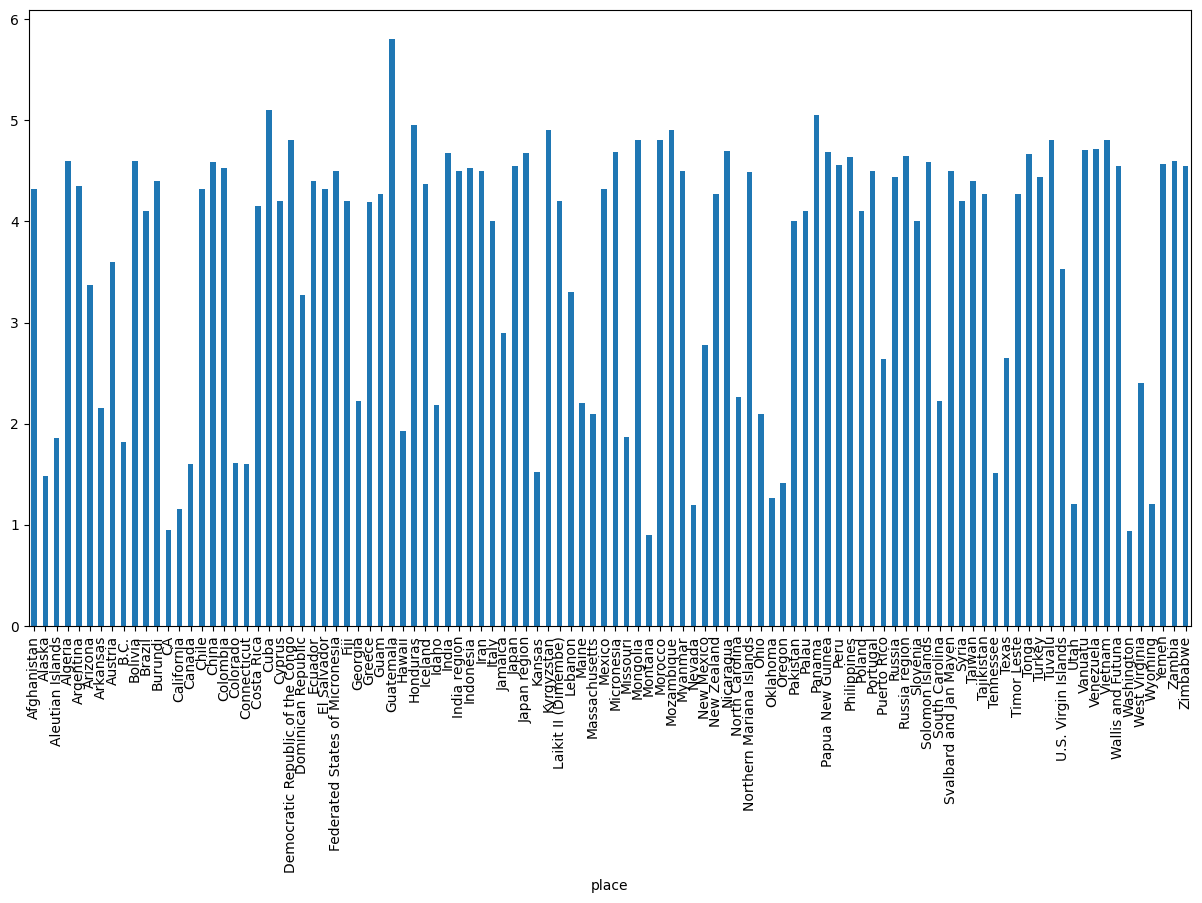

In [15]:
df.groupby(['place'])['mag'].mean().plot(kind='bar',figsize=(15,8));

<Axes: xlabel='place'>

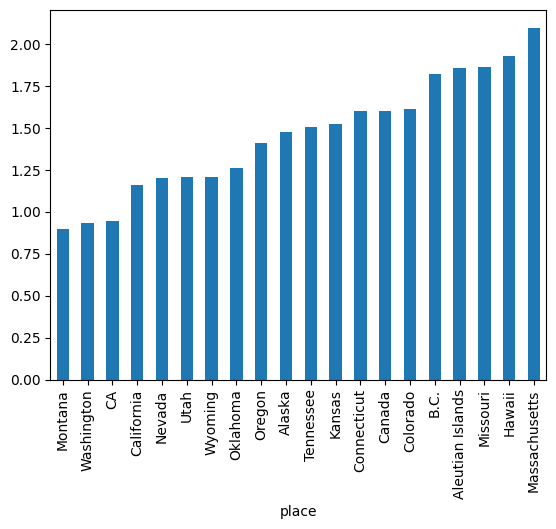

In [16]:
df.groupby(['place'])['mag'].mean().nsmallest(20).plot(kind='bar')

<Axes: xlabel='place'>

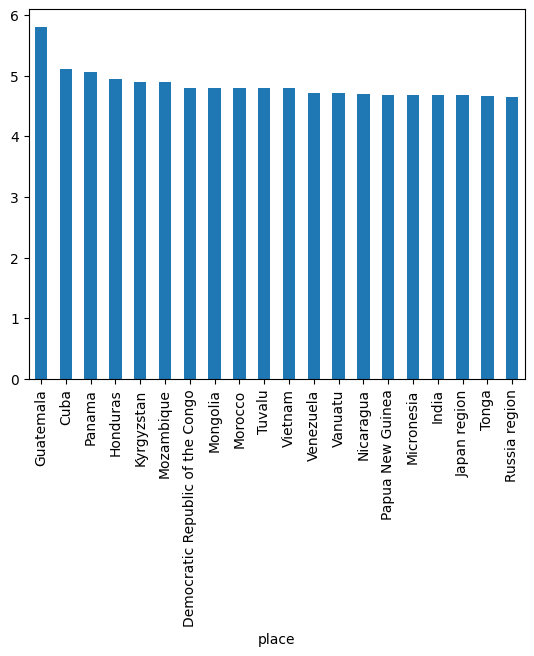

In [17]:
df.groupby(['place'])['mag'].mean().nlargest(20).plot(kind='bar')

In [18]:
more_dangerous_places=df.groupby('place')['mag'].mean()
more_dangerous_places=more_dangerous_places[more_dangerous_places>3]

##### Lets consider 3 as threshold for how high the earthquake has hit and lets visualise countries with more than 3 magnitude.

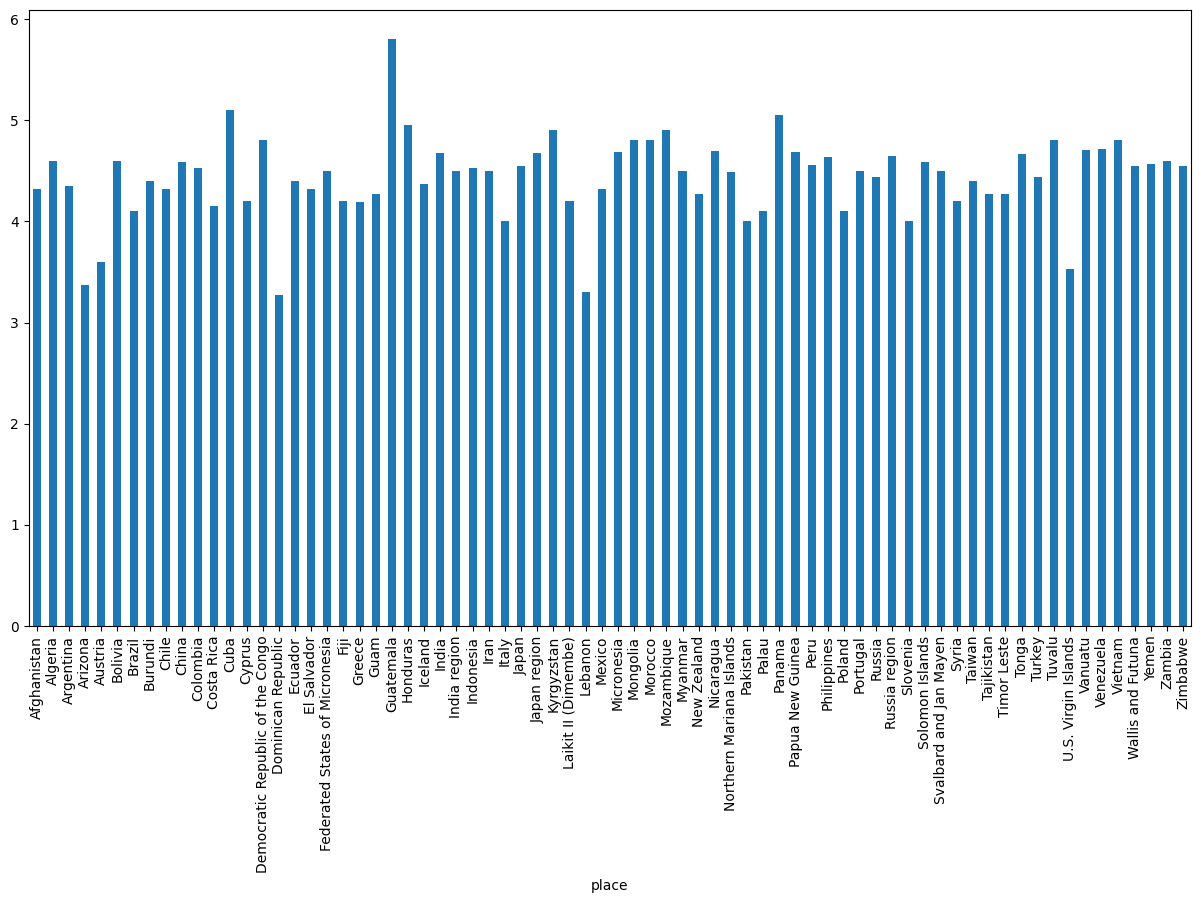

In [19]:
more_dangerous_places.plot(kind='bar',figsize= (15,8));

In [20]:
# calculate mean latitude and longitude for simplified locations

df_coords = df[['place', 'latitude', 'longitude']]
df_coords = df_coords.groupby(['place'], as_index=False).mean()
df_coords = df_coords[['place', 'latitude', 'longitude']]

In [21]:
df_coords.head()

,place,latitude,longitude
0,Afghanistan,36.193185,70.423477
1,Alaska,58.542318,-154.320064
2,Aleutian Islands,51.804107,102.265774
3,Algeria,36.570975,5.194975
4,Argentina,-27.577200,-67.500265


#### Merge the two dataframes of mean latitude and longitude locations calculated above with dataframe only considering ['date' , 'depth', 'mag', 'place'] as columns out of total features

In [22]:
df = df[['date', 'depth', 'mag', 'place']]
df = pd.merge(left=df, right=df_coords, how='inner', on=['place'])
df.head()

print('total locations:',len(set(df['place'])))

total locations: 104


In [23]:
print(set(df['place']))

{'India', 'Mozambique', 'Costa Rica', 'Cuba', 'Georgia', 'Algeria', 'Poland', 'Argentina', 'Ohio', 'New Mexico', 'India region', 'Oklahoma', 'B.C.', 'Burundi', 'California', 'Peru', 'Federated States of Micronesia', 'Massachusetts', 'Palau', 'Indonesia', 'Tajikistan', 'Timor Leste', 'Canada', 'Wyoming', 'Missouri', 'Cyprus', 'Colorado', 'Philippines', 'Zimbabwe', 'Portugal', 'Wallis and Futuna', 'Honduras', 'Chile', 'Venezuela', 'New Zealand', 'Myanmar', 'Lebanon', 'Aleutian Islands', 'Papua New Guinea', 'Laikit II (Dimembe)', 'Svalbard and Jan Mayen', 'Oregon', 'Arkansas', 'Utah', 'Taiwan', 'Iran', 'Pakistan', 'Nicaragua', 'Micronesia', 'Vietnam', 'Tonga', 'Idaho', 'Arizona', 'North Carolina', 'Morocco', 'Kansas', 'Alaska', 'U.S. Virgin Islands', 'Jamaica', 'Texas', 'Italy', 'Washington', 'CA', 'Mongolia', 'Greece', 'Russia', 'Russia region', 'Northern Mariana Islands', 'Mexico', 'Tuvalu', 'Ecuador', 'Montana', 'Puerto Rico', 'Hawaii', 'South Carolina', 'Colombia', 'Japan region', 'Co

In [24]:
df.head()

,date,depth,mag,place,latitude,longitude
0,2020-07-12,15.0,1.1,Alaska,58.542318,-154.320064
1,2020-07-12,107.2,1.1,Alaska,58.542318,-154.320064
2,2020-07-12,3.3,0.9,Alaska,58.542318,-154.320064
3,2020-07-12,107.8,1.2,Alaska,58.542318,-154.320064
4,2020-07-12,37.6,1.6,Alaska,58.542318,-154.320064


#### Feature Engineering and Data wrangling

* Set rolling window size for future prediction based on past values with fixed window size in past
* I have created 6 new features based on rolling window size on average depth and average magnitude.
* A final outcome 'mag_outcome' has been defined as target values and the output is considered as shifted values from set rolling window of past days eg: '7'. 

In [25]:
eq_tmp = df.copy()

#rolling window size
DAYS_OUT_TO_PREDICT = 7

# loop through each zone and apply MA
eq_data = []
eq_data_last_days_out = []

for place in list(set(eq_tmp['place'])):
    temp_df = eq_tmp[eq_tmp['place'] == place].copy()
    
    #avg. depth of 22 days rolling period and so on..
    temp_df['depth_avg_22'] = temp_df['depth'].rolling(window=22,center=False).mean() 
    temp_df['depth_avg_15'] = temp_df['depth'].rolling(window=15,center=False).mean()
    temp_df['depth_avg_7'] = temp_df['depth'].rolling(window=7,center=False).mean()
    temp_df['mag_avg_22'] = temp_df['mag'].rolling(window=22,center=False).mean() 
    temp_df['mag_avg_15'] = temp_df['mag'].rolling(window=15,center=False).mean()
    temp_df['mag_avg_7'] = temp_df['mag'].rolling(window=7,center=False).mean()
    temp_df.loc[:, 'mag_outcome'] = temp_df.loc[:, 'mag_avg_7'].shift(DAYS_OUT_TO_PREDICT * -1)
    
    #days to predict value on earth quake data this is not yet seen or witnessed by next 7 days (consider as live next 7 days period)
    
    eq_data_last_days_out.append(temp_df.tail(DAYS_OUT_TO_PREDICT))

    eq_data.append(temp_df)

In [26]:
# concat all location-based dataframes into master dataframe
eq_all = pd.concat(eq_data)

In [27]:
eq_all.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
13594,2020-07-16,30.68,4.4,India,22.270152,93.567868,NaN,NaN,NaN,NaN,NaN,NaN,4.771429
13595,2020-07-16,10.00,4.1,India,22.270152,93.567868,NaN,NaN,NaN,NaN,NaN,NaN,4.900000
13596,2020-07-16,39.62,4.4,India,22.270152,93.567868,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
13597,2020-07-17,10.00,4.8,India,22.270152,93.567868,NaN,NaN,NaN,NaN,NaN,NaN,5.000000
13598,2020-07-17,10.00,4.6,India,22.270152,93.567868,NaN,NaN,NaN,NaN,NaN,NaN,5.157143


In [28]:
# remove any NaN fields
eq_all = eq_all[np.isfinite(eq_all['depth_avg_22'])]
eq_all = eq_all[np.isfinite(eq_all['mag_avg_22'])]
eq_all = eq_all[np.isfinite(eq_all['mag_outcome'])]

In [29]:
eq_all.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
12230,2020-07-14,6.70,1.58,Oklahoma,36.171483,-97.718347,6.717727,6.560000,7.100000,1.352273,1.271333,1.357143,1.338571
12231,2020-07-14,7.55,2.07,Oklahoma,36.171483,-97.718347,6.730000,6.682667,7.132857,1.372727,1.334667,1.527143,1.535714
12232,2020-07-14,7.39,1.89,Oklahoma,36.171483,-97.718347,6.747727,6.708667,6.940000,1.396818,1.377333,1.570000,1.335714
12233,2020-07-15,7.75,1.48,Oklahoma,36.171483,-97.718347,6.834545,6.764000,6.848571,1.383182,1.388667,1.581429,1.251429
12234,2020-07-15,7.81,1.50,Oklahoma,36.171483,-97.718347,6.841364,6.854667,6.964286,1.404545,1.385333,1.602857,1.291429


In [35]:
eq_all.describe()

,depth,mag,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
count,12675.000000,12675.000000,12675.000000,12675.000000,12675.000000,12675.000000,12675.000000,12675.000000,12675.000000,12675.000000,12675.000000
mean,13.950972,1.299098,41.603916,-125.604867,14.028544,14.019287,13.996655,1.298083,1.298371,1.298835,0.048047
std,23.762269,0.866644,12.497556,30.822380,13.117594,13.428801,14.570594,0.548935,0.562861,0.601324,0.213875
min,-3.510000,-1.430000,-24.515600,-155.420908,-0.133636,-0.476667,-2.037143,0.239091,0.207333,-0.128571,0.000000
25%,3.260000,0.730000,36.223090,-154.320064,5.886136,5.800000,5.572857,0.940909,0.935333,0.910000,0.000000
50%,7.090000,1.200000,36.223090,-118.972035,7.372727,7.494000,7.705714,1.181818,1.180667,1.184286,0.000000
75%,12.900000,1.720000,58.542318,-117.932016,21.713409,20.732000,18.512857,1.474091,1.485667,1.528571,0.000000
max,558.810000,7.800000,58.542318,148.894953,134.704091,163.042667,195.534286,4.731818,4.866667,5.014286,1.000000


In [38]:
# print(eq_all['mag_outcome'].describe())
# eq_all['mag_outcome'].value_counts()
# eq_all['mag_outcome'].describe().info()
eq_all['mag_outcome'].head()

count    12675.000000
mean         0.048047
std          0.213875
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: mag_outcome, dtype: float64
<class 'pandas.core.series.Series'>
Index: 8 entries, count to max
Series name: mag_outcome
Non-Null Count  Dtype  
--------------  -----  
8 non-null      float64
dtypes: float64(1)
memory usage: 128.0+ bytes


12230    0
12231    0
12232    0
12233    0
12234    0
Name: mag_outcome, dtype: int32

#### location after feature engineering

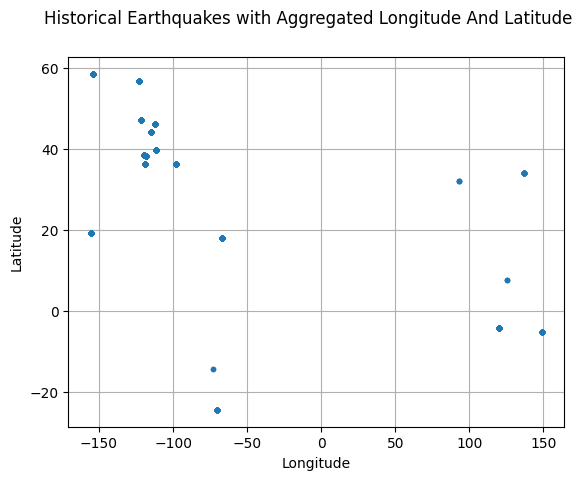

In [30]:
plt.plot(eq_all['longitude'], 
         eq_all['latitude'],
         linestyle='none', marker='.')
plt.suptitle('Historical Earthquakes with Aggregated Longitude And Latitude')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid()
plt.show()


In [31]:
# keep our live data for predictions
eq_data_last_days_out = pd.concat(eq_data_last_days_out)


eq_data_last_days_out = eq_data_last_days_out[np.isfinite(eq_data_last_days_out['mag_avg_22'])]
predict_unknown=eq_data_last_days_out

In [32]:
# here 'mag_outcome' has NaN because these are future outcome event to be predicted live or data that has not yet been witnessed
predict_unknown

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
13615,2020-07-30,10.00,4.80,India,22.270152,93.567868,14.375000,13.063333,12.481429,4.709091,4.793333,4.600000,NaN
13616,2020-07-31,36.21,4.30,India,22.270152,93.567868,14.626364,14.810667,16.225714,4.704545,4.673333,4.628571,NaN
13617,2020-08-07,104.20,4.30,India,22.270152,93.567868,18.908182,21.090667,27.201429,4.713636,4.626667,4.557143,NaN
13618,2020-08-09,10.00,4.80,India,22.270152,93.567868,17.561818,21.090667,27.201429,4.731818,4.606667,4.585714,NaN
12605,2020-08-09,7.78,0.99,Oklahoma,36.171483,-97.718347,7.548636,6.947333,6.061429,1.155000,1.251333,1.281429,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13056,2020-08-05,10.00,5.40,Japan,34.027030,137.086079,63.935000,59.558000,30.172857,4.527273,4.553333,4.671429,NaN
13057,2020-08-06,165.32,5.10,Japan,34.027030,137.086079,63.631818,68.195333,48.595714,4.563636,4.586667,4.785714,NaN
13058,2020-08-06,372.58,5.20,Japan,34.027030,137.086079,78.976364,68.122000,93.808571,4.595455,4.660000,4.885714,NaN
13059,2020-08-08,34.65,4.40,Japan,34.027030,137.086079,78.866818,68.102667,97.330000,4.604545,4.666667,4.885714,NaN


##### considered magnitude above 2.5 as dangerous hence prediction outcome as '1' elso '0'.

In [33]:
eq_all['mag_outcome'] = np.where(eq_all['mag_outcome'] > 2.5, 1,0)
print(eq_all['mag_outcome'].describe())
eq_all['mag_outcome'].value_counts()

count    12675.000000
mean         0.048047
std          0.213875
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: mag_outcome, dtype: float64


0    12066
1      609
Name: mag_outcome, dtype: int64

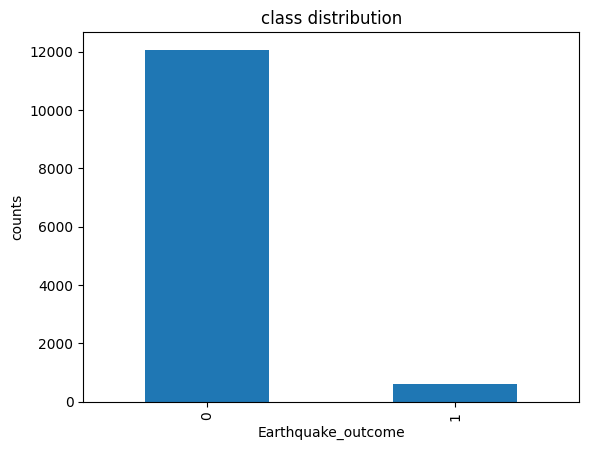

In [34]:
eq_all['mag_outcome'].value_counts().plot(kind='bar',)
plt.xlabel('Earthquake_outcome')
plt.ylabel('counts')
plt.title('class distribution');